Titulo: “Predicción de Gravedad Clínica en Enfermedades del Tracto Respiratorio Superior: Análisis Multivariable y Modelos de Aprendizaje Automático"

Equipo: . Javiera Ignacia Cea Carreño- 21.436.859-5, Paolo Leonardo Mauricio Messina Alvarado- 21.091.083-2, Constanza Camila Vergara Gavilan- 21.144.343-K

Este proyecto busca predecir la gravedad clínica de pacientes adultos con enfermedades del tracto respiratorio superior en servicios de urgencia, utilizando datos de la encuesta NHAMCS (años 2015, 2016, 2017, 2018, 2019 y 2022). El objetivo principal es desarrollar un modelo de Machine Learning capaz de identificar casos de alta gravedad clínica utilizando atributos clínicos y demográficos.

Objetivos:
1. Desarrollar un modelo de Machine Learning para predecir la gravedad clínica (high_acuity) de pacientes adultos con enfermedades respiratorias del tracto superior, utilizando los datos de la encuesta NHAMCS de los años 2015, 2016, 2017, 2018, 2019 y 2022.

2. Realizar un análisis exploratorio descriptivo (EDA) para caracterizar la población con high_acuity, explorando su distribución sexo, estación del año, comorbilidades, signos clínicos e intervenciones.

3. Crear un dashboard interactivo (en powe BI) que permita explorar las predicciones del modelo junto con las variables predictoras clave.

4. Implementar y comparar al menos dos modelos distintos (Regresión Logística y Random Forest) para la misma tarea de predicción.

5. Validar rigurosamente el modelo con classification report (precisión, recall, F1-score) y AUC-ROC.

6. Lograr que el modelo con mejor desempeño alcance al menos 85 % de precisión en el conjunto de prueba.

Para llevar a cabo el presente proyecto de ciencia de datos, se utilizaron bases de datos del National Hospital Ambulatory Medical Care Survey (NHAMCS) correspondientes a los años 2015, 2016, 2017, 2018, 2019 y 2022. Cada conjunto de datos fue cargado en el entorno de análisis utilizando la función read_sas() de la biblioteca pandas, dado que los archivos originales estaban en formato SAS (.sas7bdat). A continuación, se incorporó una columna denominada YEAR para identificar el año correspondiente a cada registro, facilitando así el análisis temporal posterior. Finalmente, todos los conjuntos de datos fueron consolidados en un único dataframe mediante la función concat(), preservando el orden cronológico inverso y asegurando una estructura uniforme para el análisis exploratorio y la modelación estadística posterior.

In [3]:
import pandas as pd
import numpy as np
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
uploaded = files.upload()

data2015 = pd.read_sas('ed2015_sas.sas7bdat',format='sas7bdat')
data2016 = pd.read_sas('ed2016_sas.sas7bdat',format='sas7bdat')
data2017 = pd.read_sas('ed2017_sas.sas7bdat',format='sas7bdat')
data2018 = pd.read_sas('ed2018_sas.sas7bdat',format='sas7bdat')
data2022 = pd.read_sas('ed2022_sas.sas7bdat',format='sas7bdat')
data2019 = pd.read_sas('ed2019_sas.sas7bdat',format='sas7bdat')
data2015['YEAR'] = 2015
data2016['YEAR'] = 2016
data2017['YEAR'] = 2017
data2018['YEAR'] = 2018
data2019['YEAR'] = 2019
data2022['YEAR'] = 2022
data = pd.concat([data2019, data2022, data2018, data2017, data2016, data2015], ignore_index=True)


Saving ed2019_sas.sas7bdat to ed2019_sas.sas7bdat
Saving ed2022_sas.sas7bdat to ed2022_sas.sas7bdat
Saving ed2017_sas.sas7bdat to ed2017_sas.sas7bdat
Saving ed2018_sas.sas7bdat to ed2018_sas.sas7bdat
Saving ed2015_sas.sas7bdat to ed2015_sas.sas7bdat
Saving ed2016_sas.sas7bdat to ed2016_sas.sas7bdat


A continuación se presenta una descripción detallada de las variables seleccionadas para el análisis del conjunto de datos NHAMCS, indicando tanto su significado clínico como su tipo de medición. Esta selección responde a criterios clínicos y analíticos orientados a explorar factores sociodemográficos, signos vitales, motivos de consulta y diagnósticos asociados a condiciones respiratorias y cardiovasculares, entre otras.

Las variables incluyen datos temporales como el mes (VMONTH) y año (YEAR) de la visita; características del paciente como la edad (AGE), sexo (SEX), raza/etnia (RACEUN) y origen hispano (ETHUN); y parámetros fisiológicos como la temperatura corporal (TEMPF), frecuencia cardíaca (PULSE), presión arterial sistólica (BPSYS), y saturación de oxígeno (POPCT).

Asimismo, se incorporan variables clínicas de alta relevancia como la escala de dolor reportada (PAINSCALE), los principales motivos de consulta (RFV1 a RFV5), y hasta cinco diagnósticos registrados en codificación ICD-10 (DIAG1 a DIAG5). Finalmente, se consideran condiciones crónicas y tratamientos recibidos durante la visita, como EPOC (COPD), hipertensión (HTN), insuficiencia cardíaca congestiva (CHF), y administración de fluidos intravenosos (IVFLUIDS) o terapia nebulizada (NEBUTHER).

Estas variables, clasificadas según sus niveles de medición (nominal, ordinal, intervalo o razón), permitirán aplicar técnicas estadísticas y de machine learning adecuadas para describir, modelar y predecir patrones clínicos relevantes en el contexto de atención ambulatoria en servicios de urgencia.

In [4]:
variables_info = {
    'VMONTH': ("Mes de la visita", "Nominal"),
    'YEAR': ('Año en que ocurrió la visita', 'Intervalo'),
    'AGE': ('Edad del paciente (años)', 'Razón'),
    'SEX': ('Sexo del paciente (1=Femenino, 2=Masculino)', 'Nominal'),
    'RACEUN': ('Raza/etnia del paciente (categorías agrupadas)', 'Nominal'),
    'ETHUN': ('Origen hispano del paciente (1=Sí, 2=No)', 'Nominal'),
    'TEMPF': ('Temperatura del paciente (°F)', 'Razón'),
    'PULSE': ('Frecuencia cardíaca (lpm)', 'Razón'),
    'BPSYS': ('Presión arterial sistólica (mmHg)', 'Razón'),
    'POPCT': ('Oximetría de pulso (SpO2)', 'Razón'),
    'PAINSCALE':('Escala del dolor (1-10)', 'Ordinal'),
    'RFV1': ('Primer motivo de consulta', 'Nominal'),
    'RFV2': ('Segundo motivo de consulta', 'Nominal'),
    'RFV3': ('Tercer motivo de consulta', 'Nominal'),
    'RFV4': ('Cuarto motivo de consulta', 'Nominal'),
    'RFV5': ('Quinto motivo de consulta', 'Nominal'),
    'DIAG1': ('Diagnóstico principal (ICD-10)', 'Nominal'),
    'DIAG2': ('Segundo diagnóstico (ICD-10)', 'Nominal'),
    'DIAG3': ('Tercer diagnóstico (ICD-10)', 'Nominal'),
    'DIAG4': ('Cuarto diagnóstico (ICD-10)', 'Nominal'),
    'DIAG5': ('Quinto diagnóstico (ICD-10)', 'Nominal'),
    'COPD': ('Paciente con EPOC (1=Sí, 0=No)', 'Nominal'),
    'HTN': ('Paciente con Hipertensión (1=Sí, 0=No)', 'Nominal'),
    'CHF': ('Paciente con Insuficiencia Cardíaca Congestiva (1=Sí, 0=No)', 'Nominal'),
    'IVFLUIDS': ('Fluidos intravenosos administrados (1=Sí, 0=No)', 'Nominal'),
    'NEBUTHER': ('Terapia de nebulización administrada (1=Sí, 0=No)', 'Nominal')

}


 A continuación se prepara un subconjunto de datos provenientes del NHAMCS con el fin de analizar específicamente los casos de enfermedades del tracto respiratorio superior en pacientes adultos. El proceso comienza con la definición de una lista llamada enfermedades_tracto_superior, que contiene una serie de códigos de diagnóstico basados en el sistema de codificación ICD-10. Esta lista incluye códigos como ‘J00’ (resfriado común), ‘J01’ (sinusitis aguda), ‘J03’ (amigdalitis aguda), entre muchos otros que abarcan afecciones respiratorias altas comunes. También se incluyen algunos códigos del capítulo H (como H65 y H66), correspondientes a otitis media, ya que se consideran parte del sistema respiratorio superior en ciertos contextos clínicos.

Posteriormente, se define una función llamada preparar_datos_enfermedades_tracto_superior, que recibe como entrada un conjunto de datos de un año específico y el valor numérico de ese año. Lo primero que hace esta función es filtrar los registros para quedarse únicamente con los pacientes adultos, es decir, aquellos cuya edad es igual o mayor a 18 años. Luego, se define una lista de variables útiles que abarcan características demográficas (sexo, etnia, mes de visita), razones de consulta (RFV1 a RFV5), hasta cinco posibles diagnósticos registrados (DIAG1 a DIAG5), además de datos clínicos como edad, temperatura, frecuencia cardíaca, presión arterial, oximetría de pulso, escala de dolor, y presencia de comorbilidades respiratorias o cardiovasculares, junto con el uso de intervenciones como fluidos intravenosos o terapia nebulizada.

Dado que no todos los conjuntos de datos de cada año contienen exactamente las mismas columnas, la función evalúa cuáles de esas variables útiles están disponibles y conserva solo las columnas existentes. A continuación, se limpian los campos de diagnóstico para garantizar uniformidad: se convierten a texto, se eliminan espacios en blanco y se remueven los guiones para que los códigos queden estandarizados y comparables con los de la lista inicial. Una vez procesados, se aplica una condición lógica para identificar a los pacientes que presentan al menos uno de esos diagnósticos en cualquiera de las cinco columnas de diagnóstico. Solo esos pacientes son conservados, y a su vez se les asigna el valor del año correspondiente mediante la columna YEAR.

La tercera parte del código concatena los datos de varios años (2015, 2016, 2017, 2018, 2019 y 2022) usando esta función. Para cada uno de esos años, se aplica la función preparar_datos_enfermedades_tracto_superior sobre su conjunto de datos respectivo, y los resultados se unen en un solo dataframe llamado data_filtrada, que reúne todos los pacientes adultos diagnosticados con enfermedades del tracto respiratorio superior. Luego, se procede a una limpieza adicional: se reemplazan los valores negativos utilizados por NHAMCS para codificar datos faltantes (como -7, -8, -9, -5) por valores estándar de NaN, lo que permite manejar adecuadamente la información ausente en los análisis posteriores. Finalmente, se elimina cualquier columna duplicada que pudiera haberse generado durante la concatenación, asegurando una estructura limpia y consistente del conjunto de datos final.

In [5]:
# 1. Lista de enfermedades del tracto superior (ICD-10)
enfermedades_tracto_superior = [
    'J010', 'J011', 'J012', 'J013', 'J014', 'J018', 'J019',
    'J020', 'J028', 'J029',
    'J030', 'J038', 'J039',
    'J040', 'J041', 'J042',
    'J060', 'J068', 'J069',
    'J101', 'J111',
    'H65', 'H66',
    'J00', 'J01', 'J02', 'J03', 'J04', 'J05', 'J06', 'J10', 'J11'
]

# 2. Preparar pacientes adultos con enfermedades respiratorias
def preparar_datos_enfermedades_tracto_superior(data, year):
    data_adultos = data[data['AGE'] >= 18].copy()

    variables_utiles = [
        'SEX', 'RACEUN', 'ETHUN', 'VMONTH',
        *['RFV' + str(i) for i in range(1, 6)],
        'DIAG1', 'DIAG2', 'DIAG3', 'DIAG4', 'DIAG5', 'YEAR',
        'AGE', 'TEMPF', 'PULSE', 'BPSYS', 'POPCT', 'PAINSCALE', 'COPD', 'HTN', 'CHF',
        'IVFLUIDS', 'NEBUTHER'
    ]

    columnas_existentes = [col for col in variables_utiles if col in data_adultos.columns]
    data_adultos = data_adultos[columnas_existentes].copy()

    diag_cols = ['DIAG1', 'DIAG2', 'DIAG3', 'DIAG4', 'DIAG5']
    for col in diag_cols:
        data_adultos[col] = data_adultos[col].astype(str).str.strip()
        data_adultos[col] = data_adultos[col].replace({'-9': None, '-8': None, '-7': None})
        data_adultos[col] = data_adultos[col].str.replace('-', '', regex=False)


    mask = data_adultos[diag_cols].apply(lambda col: col.isin(enfermedades_tracto_superior)).any(axis=1)
    data_filtrada = data_adultos[mask].copy()
    data_filtrada['YEAR'] = year
    return data_filtrada

# 3. Unir datos de todos los años
data_filtrada = pd.concat([
    preparar_datos_enfermedades_tracto_superior(data2022, 2022),
    preparar_datos_enfermedades_tracto_superior(data2019, 2019),
    preparar_datos_enfermedades_tracto_superior(data2018, 2018),
    preparar_datos_enfermedades_tracto_superior(data2017, 2017),
    preparar_datos_enfermedades_tracto_superior(data2016, 2016),
    preparar_datos_enfermedades_tracto_superior(data2015, 2015)
], ignore_index=True)

data_filtrada.replace([-7, -8, -9, -5], np.nan, inplace=True)
data_filtrada = data_filtrada.loc[:, ~data_filtrada.columns.duplicated()]

El siguiente fragmento del código tiene como objetivo complementar el análisis clínico de pacientes adultos diagnosticados con enfermedades del tracto respiratorio superior, clasificándolos según criterios epidemiológicos, clínicos y estacionales, para finalmente identificar los niveles de gravedad o “high acuity” asociados a cada caso.

El proceso comienza con la clasificación de los pacientes en grupos etarios. Para ello, se define una función llamada asignar_grupo_edad que categoriza la edad en cinco rangos: de 18 a 24, de 25 a 44, de 45 a 64, de 65 a 74, y mayores de 75 años. Esta categorización permite analizar las diferencias clínicas y epidemiológicas entre tramos etarios, lo cual es fundamental en estudios de salud pública. La función se aplica sobre la columna de edad (AGE) y su resultado se almacena en una nueva columna llamada AGE_GROUP.

Luego, se realiza una clasificación de los motivos de consulta respiratorios utilizando los códigos de las variables RFV (Reason For Visit), que en NHAMCS están representadas por múltiples columnas (RFV1 a RFV5). Se crea un diccionario llamado Razon_visita que agrupa ciertos códigos numéricos en categorías clínicas como disnea, infección de vías respiratorias superiores, fiebre y tos. Posteriormente, se define una función (clasificar_rfv_respiratorio) que evalúa cada uno de estos códigos y los clasifica dentro de las categorías previamente definidas. Esta función se aplica a cada columna RFV disponible, generando nuevas columnas que indican a qué categoría respiratoria pertenece cada motivo de consulta. Finalmente, se utiliza una técnica de relleno hacia atrás (bfill) para extraer el primer motivo respiratorio válido y asignarlo a una nueva columna unificada: Razon de visita.

En la siguiente etapa, se crean variables clínicas derivadas con el fin de identificar rápidamente condiciones de riesgo. Se define INTERVENCION_AGUDA_INICIAL como una variable binaria que indica si el paciente recibió fluidos intravenosos o terapia nebulizada, lo que suele ser indicativo de una condición aguda o grave. Asimismo, se define COMORB_CARDIOPULMONAR, otra variable binaria que refleja la presencia de condiciones preexistentes como enfermedad pulmonar obstructiva crónica (EPOC), hipertensión o insuficiencia cardíaca. Además, se calcula una variable compuesta llamada SIGNOS_GRAVES, que contabiliza si se presentan anormalidades clínicas relevantes: pulso elevado (≥125 lpm), saturación de oxígeno baja (<88%), presión sistólica muy baja (<80 mmHg) o fiebre (>100.4 °F).

Con base en todos estos datos, se procede a clasificar a los pacientes según un sistema de niveles de gravedad, denominado High_acuity_level. Para ello se define una función que evalúa varios criterios combinados. Si un paciente presenta disnea y es mayor de 65 años, o si recibió una intervención aguda o presenta una comorbilidad cardiopulmonar, se lo clasifica como de nivel 1 (Alta). Si presenta dolor intenso (≥7), fiebre en pacientes mayores de 45 años, o algún signo grave, se asigna nivel 2 (Media). Si el motivo de consulta es fiebre, tos o infección de vías superiores y tiene entre 18 y 44 años, se asigna nivel 3 (Baja). El resto se clasifica como nivel 4 (Desconocido). Posteriormente, los niveles numéricos se traducen a etiquetas categóricas (Alta, Media, Baja, Desconocido) para facilitar la interpretación.

Después, el análisis incorpora una dimensión temporal estacional. Mediante la función obtener_estacion, se asigna una estación del año (Invierno, Primavera, Verano, Otoño) a cada visita, utilizando el número de mes (VMONTH). Esto permite explorar posibles patrones estacionales en la gravedad de los casos. Se elimina cualquier registro que no tenga el mes especificado, y se agrega la estación correspondiente como una nueva columna.

Finalmente, se presentan los resultados. Primero, se imprime la cantidad total de pacientes filtrados con enfermedades del tracto respiratorio superior. Luego, se muestra la distribución de los niveles de gravedad tanto en su versión numérica (High_acuity_level) como categórica (high_acuity). Para complementar, se genera una tabla resumen que cruza el nivel de gravedad con el año y la estación del año, mostrando la cantidad de casos por categoría.

In [6]:

# 4. Clasificar grupo etario
def asignar_grupo_edad(edad):
    if 18 <= edad <= 24: return '18–24'
    elif 25 <= edad <= 44: return '25–44'
    elif 45 <= edad <= 64: return '45–64'
    elif 65 <= edad <= 74: return '65–74'
    elif edad >= 75: return '75+'
    return np.nan

data_filtrada['AGE_GROUP'] = data_filtrada['AGE'].apply(asignar_grupo_edad)

# 5. Clasificar RFV respiratorios
Razon_visita = {
    'DISNEA': ['14150.0', '14200.0', '14250.0', '14300.0'],
    'INFECCION_VIAS_SUPERIORES': ['14450.0', '14550.0', '14600.0', '26000.0', '26050.0', '13900.0', '13920.0', '13950.0', '13980.0'],
    'FIEBRE': ['10100.0', '10050.0', '10120.0'],
    'TOS': ['14500.0']
}

def clasificar_rfv_respiratorio(valor):
    if pd.isnull(valor): return None
    t = str(valor).upper().strip()
    for categoria, codigos in Razon_visita.items():
        if t in codigos or any(c in t for c in codigos):
            return categoria
    return None

for i in range(1, 6):
    col = f'RFV{i}'
    if col in data_filtrada.columns:
        data_filtrada[f'{col}_visita'] = data_filtrada[col].apply(clasificar_rfv_respiratorio)

rfv_visita_cols = [f'RFV{i}_visita' for i in range(1, 31) if f'RFV{i}_visita' in data_filtrada.columns]
data_filtrada['Razon de visita'] = data_filtrada[rfv_visita_cols].bfill(axis=1).iloc[:, 0]

# 6. Variables clínicas
data_filtrada['INTERVENCION_AGUDA_INICIAL'] = (
    (data_filtrada['IVFLUIDS'] == 1) |
    (data_filtrada['NEBUTHER'] == 1)
).astype(int)

data_filtrada['COMORB_CARDIOPULMONAR'] = (
    (data_filtrada['COPD'] == 1) |
    (data_filtrada['HTN'] == 1) |
    (data_filtrada['CHF'] == 1)
).astype(int)

data_filtrada['SIGNOS_GRAVES'] = (
    (data_filtrada['PULSE'] >= 125).astype(int) +
    (data_filtrada['POPCT'] < 88).astype(int) +
    (data_filtrada['BPSYS'] < 80).astype(int) +
    (data_filtrada['TEMPF'] > 100.4).astype(int)
)

# 7. Definir niveles de High Acuity
def definir_nivel_acuity(fila):
    razon = fila.get('Razon de visita')
    edad = fila.get('AGE_GROUP')
    signos = fila.get('SIGNOS_GRAVES')
    painscale = fila.get('PAINSCALE', np.nan)
    intervencion = fila.get('INTERVENCION_AGUDA_INICIAL', np.nan)
    comorbilidad = fila.get('COMORB_CARDIOPULMONAR', np.nan)

    if (
        (razon == 'DISNEA' and edad in ['65–74', '75+']) or
        (intervencion == 1) or
        (comorbilidad == 1)
    ):
        return 1
    if (
        (pd.notna(painscale) and painscale >= 7) or
        (razon == 'FIEBRE' and edad in ['45–64','65–74', '75+']) or
        (signos == 1)
    ):
        return 2
    if (
       (razon in ['TOS', 'FIEBRE', 'INFECCION_VIAS_SUPERIORES'] and
        edad in ['18–24', '25–44'])
    ):
        return 3
    return 4

data_filtrada['High_acuity_level'] = data_filtrada.apply(definir_nivel_acuity, axis=1)

def categorizar_high_acuity(nivel):
    if nivel == 1:
        return 'Alta'
    elif nivel == 2:
        return 'Media'
    elif nivel == 3:
        return 'Baja'
    return 'Desconocido'

data_filtrada['high_acuity'] = data_filtrada['High_acuity_level'].apply(categorizar_high_acuity)

# 8. Estación del año
def obtener_estacion(mes):
    if mes in [12, 1, 2]: return 'Invierno'
    elif mes in [3, 4, 5]: return 'Primavera'
    elif mes in [6, 7, 8]: return 'Verano'
    elif mes in [9, 10, 11]: return 'Otoño'
    return 'Desconocido'

data_filtrada = data_filtrada.dropna(subset=['VMONTH'])
data_filtrada['ESTACION'] = data_filtrada['VMONTH'].astype(int).apply(obtener_estacion)

# 9. Resultados finales
print("Cantidad total de pacientes con enfermedades del tracto superior:", len(data_filtrada))
print("\nDistribución de High_acuity_level:")
print(data_filtrada['High_acuity_level'].value_counts(dropna=False))
print("\nDistribución de high_acuity:")
print(data_filtrada['high_acuity'].value_counts(dropna=False))

# 10. Tabla resumen: distribución de high_acuity por año y estación
tabla_resumen = data_filtrada.groupby(['YEAR', 'ESTACION'])['high_acuity'].value_counts().unstack().fillna(0).astype(int).reset_index()

# Mostrar resultados
print("\nDistribución de High Acuity (Alta, Media, Baja, Desconocido) por Año y Estación:")
print(tabla_resumen)


Cantidad total de pacientes con enfermedades del tracto superior: 2740

Distribución de High_acuity_level:
High_acuity_level
2    1576
1    1084
4      66
3      14
Name: count, dtype: int64

Distribución de high_acuity:
high_acuity
Media          1576
Alta           1084
Desconocido      66
Baja             14
Name: count, dtype: int64

Distribución de High Acuity (Alta, Media, Baja, Desconocido) por Año y Estación:
high_acuity  YEAR   ESTACION  Alta  Baja  Desconocido  Media
0            2016   Invierno    65     0            3     69
1            2016      Otoño    53     0            8    101
2            2016  Primavera    58     1            3     82
3            2016     Verano    41     0            2     72
4            2017   Invierno   102     4            3    119
5            2017      Otoño    50     0            0     61
6            2017  Primavera    36     0            0     42
7            2017     Verano    18     0            2     57
8            2018   Invierno  

Los **RESULTADOS** muestran un total de 2.740 pacientes adultos diagnosticados con enfermedades del tracto respiratorio superior. Al analizar la distribución de gravedad clínica (high_acuity), se observa que:

57,5% (1.576 pacientes) fueron clasificados con gravedad media, lo que representa la categoría más frecuente.

39,6% (1.084 pacientes) fueron clasificados con gravedad alta, indicando un grupo clínicamente relevante con posibles signos o condiciones agudas.

Un 2,4% (66 pacientes) fueron etiquetados como "Desconocido", lo que sugiere falta de información suficiente para su categorización.

Solo un 0,5% (14 pacientes) fueron considerados de gravedad baja, lo cual podría estar relacionado con criterios de selección más exigentes en este estudio o una baja incidencia de casos leves en contextos hospitalarios.

La distribución por año y estación revela algunas tendencias estacionales. Por ejemplo, la estación invierno concentra consistentemente el mayor número de casos, en especial aquellos clasificados como Alta y Media. Esto se evidencia, por ejemplo, en invierno de 2018, que registró 113 casos de gravedad alta y 203 de gravedad media, siendo el pico más elevado del periodo observado. Del mismo modo, invierno de 2017 y 2019 también reflejan altos volúmenes de casos clínicamente significativos.

Por otro lado, las estaciones de verano y primavera tienden a mostrar cifras más bajas, especialmente en la categoría "Alta". Este patrón sugiere una relación estacional clara en la gravedad de las enfermedades respiratorias del tracto superior, lo cual es consistente con el comportamiento típico de enfermedades virales y respiratorias en climas fríos.

Analisis Exploratorio EDA:
1. Clasificación de variables
Se agrupan las variables en cuatro tipos:

Nominales: categóricas sin orden (sexo, comorbilidades, estación, etc.).
Ordinales: categóricas con orden (escala de dolor y nivel de gravedad).
De razón: numéricas continuas con cero absoluto (edad, presión, pulso, etc.).
De intervalo: variables numéricas discretas como el año.

2. Análisis descriptivo
Describe estadísticamente las variables numéricas (AGE, PULSE, etc.): media, desviación estándar, min/máx, etc.
Cuenta los valores nulos en estas variables.
Muestra la distribución de frecuencias absolutas y relativas para todas las variables categóricas (nominales y ordinales).
Hace lo mismo para la variable YEAR (intervalo) y para high_acuity.

3. Visualización
Crea gráficos de barras (countplot) para cada variable nominal, mostrando su distribución.
Muestra histogramas de las variables numéricas.
Muestra boxplots de las variables numéricas para detectar outliers visualmente.
Calcula y muestra la cantidad de outliers por variable con el método del rango intercuartílico (IQR).

4. ANOVA (R²) entre categóricas y numéricas
Evalúa qué tanto las variables categóricas explican la varianza de las variables numéricas (usando ANOVA).
Solo muestra combinaciones con un coeficiente de determinación R² > 0.05, lo que indica cierta relación estadística.

5. Correlación con el outcome high_acuity
Codifica todas las variables categóricas usando dummies (One-Hot Encoding).
Codifica la variable objetivo high_acuity como numérica con LabelEncoder.
Calcula la correlación de Pearson entre cada predictor y high_acuity.
Muestra un heatmap para visualizar esas correlaciones.
Imprime solo las correlaciones fuertes (mayores a 0.3 en valor absoluto), que son potencialmente útiles para modelos predictivos.


Resumen estadístico: Variables de razón
        count        mean        std    min    25%    50%    75%     max
AGE    2740.0   39.345620  17.757563   18.0   25.0   35.0   51.0    94.0
TEMPF  2634.0  986.315110  11.912940  902.0  980.0  984.0  990.0  1040.0
PULSE  2551.0   93.020776  43.307174   18.0   80.0   90.0  102.0   998.0
BPSYS  2647.0  134.153003  20.295651   83.0  120.0  132.0  146.0   224.0
POPCT  2628.0   97.116058   5.963140    1.0   97.0   98.0   99.0   100.0

Valores nulos por variable de razón:
AGE        0
TEMPF    106
PULSE    189
BPSYS     93
POPCT    112
dtype: int64

Resumen estadístico: Variables ordinales

Distribución de PAINSCALE:
PAINSCALE
NaN     858
0.0     420
8.0     273
7.0     247
10.0    194
5.0     179
6.0     174
9.0     116
4.0     105
3.0      86
2.0      73
1.0      15
Name: count, dtype: int64
Distribución relativa (%):
PAINSCALE
NaN     31.31%
0.0     15.33%
8.0      9.96%
7.0      9.01%
10.0     7.08%
5.0      6.53%
6.0      6.35%
9.0      4.23

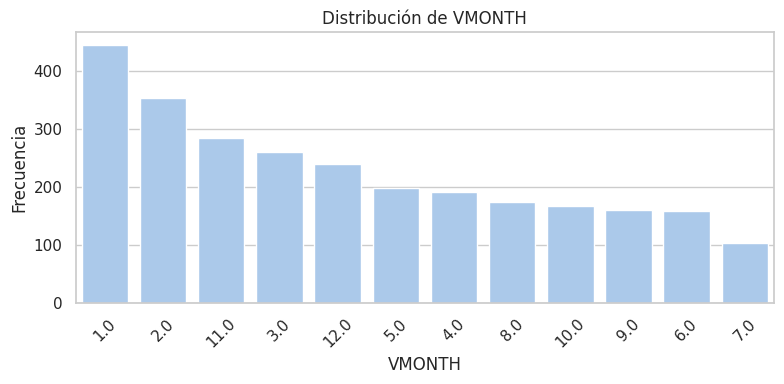

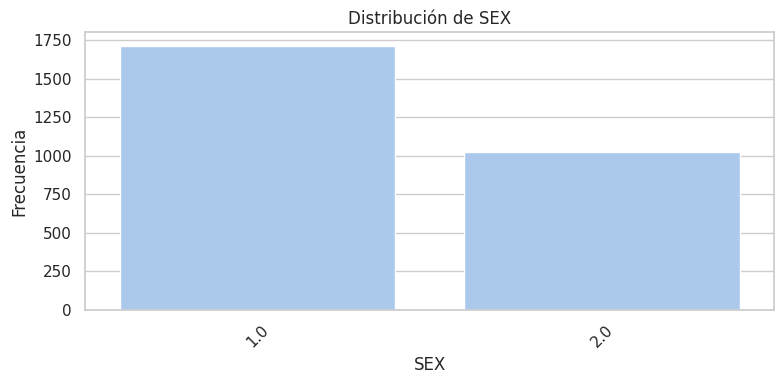

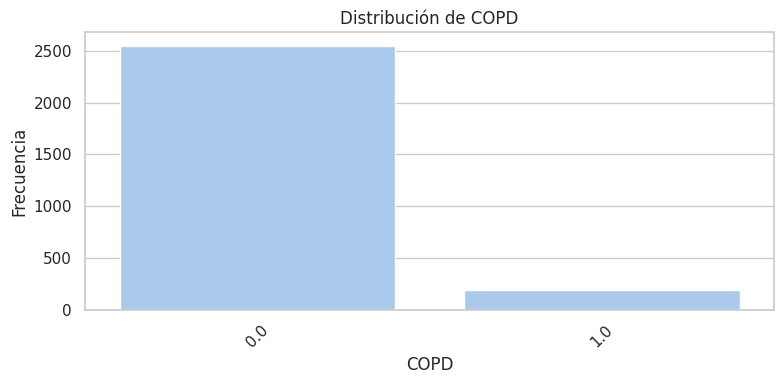

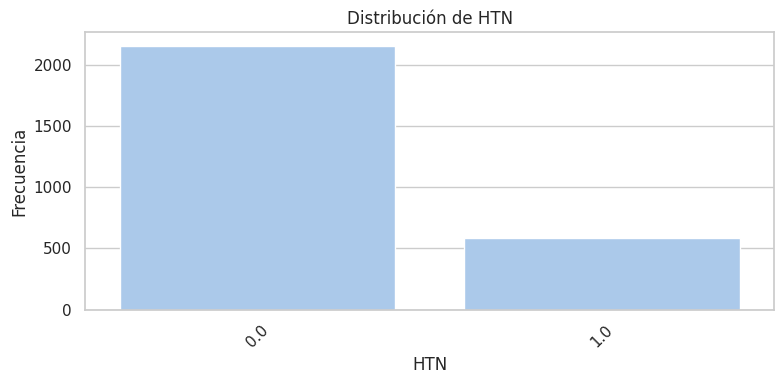

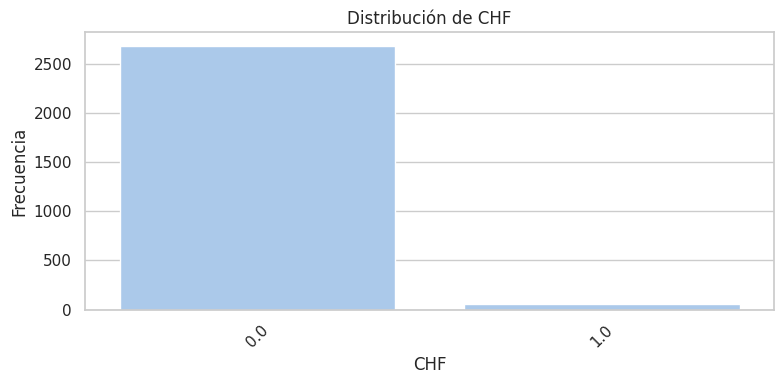

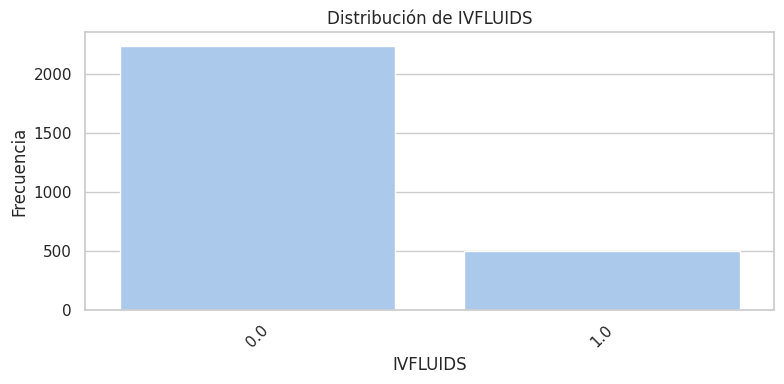

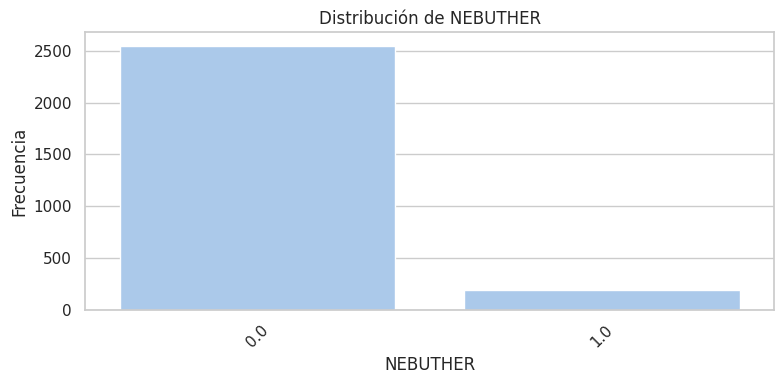

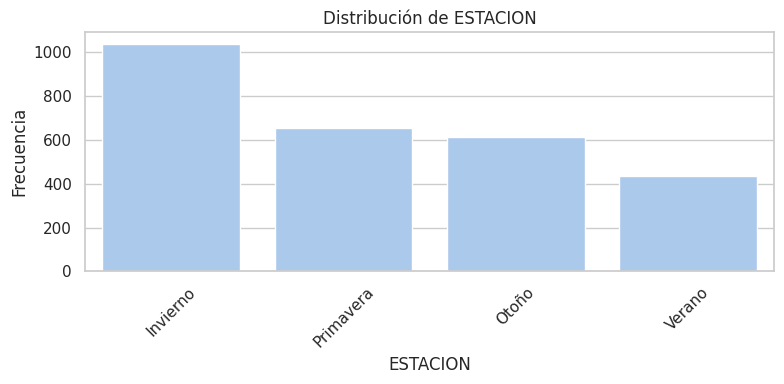

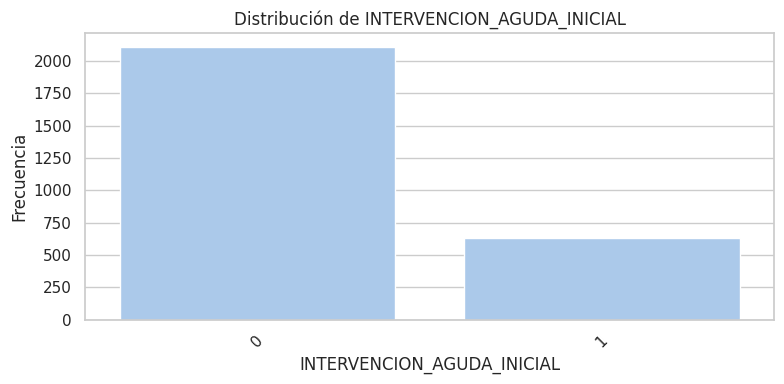

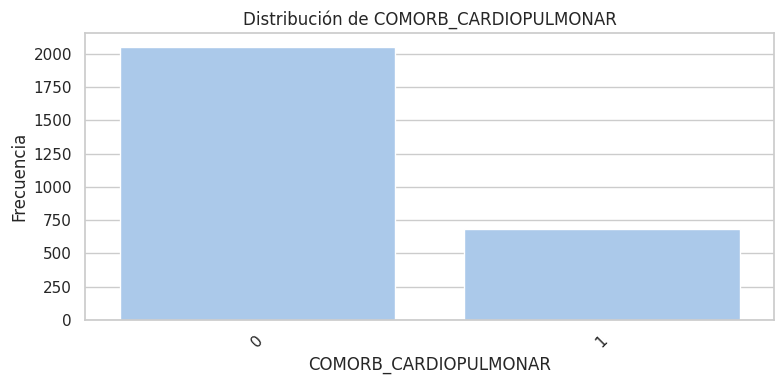

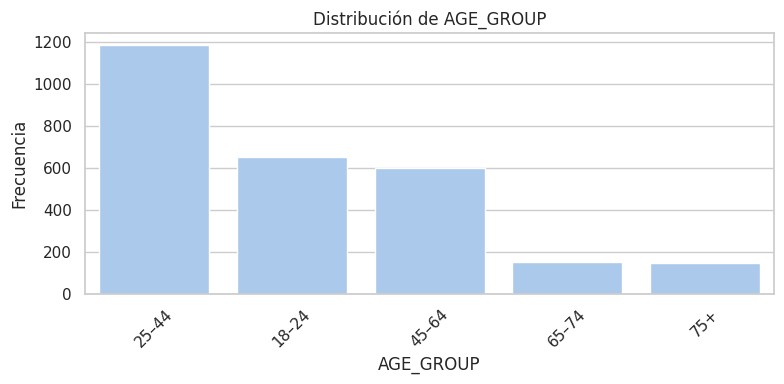

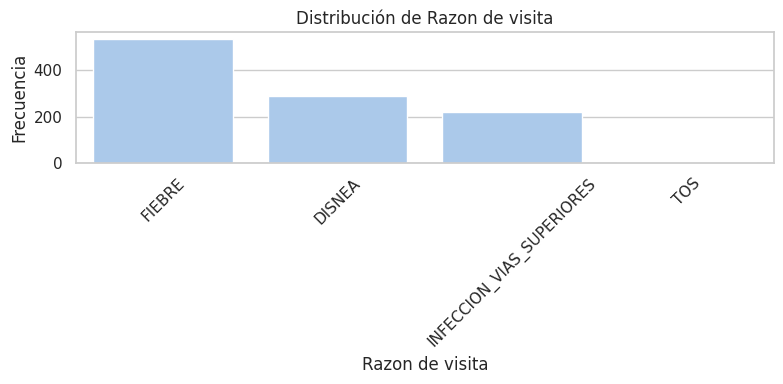

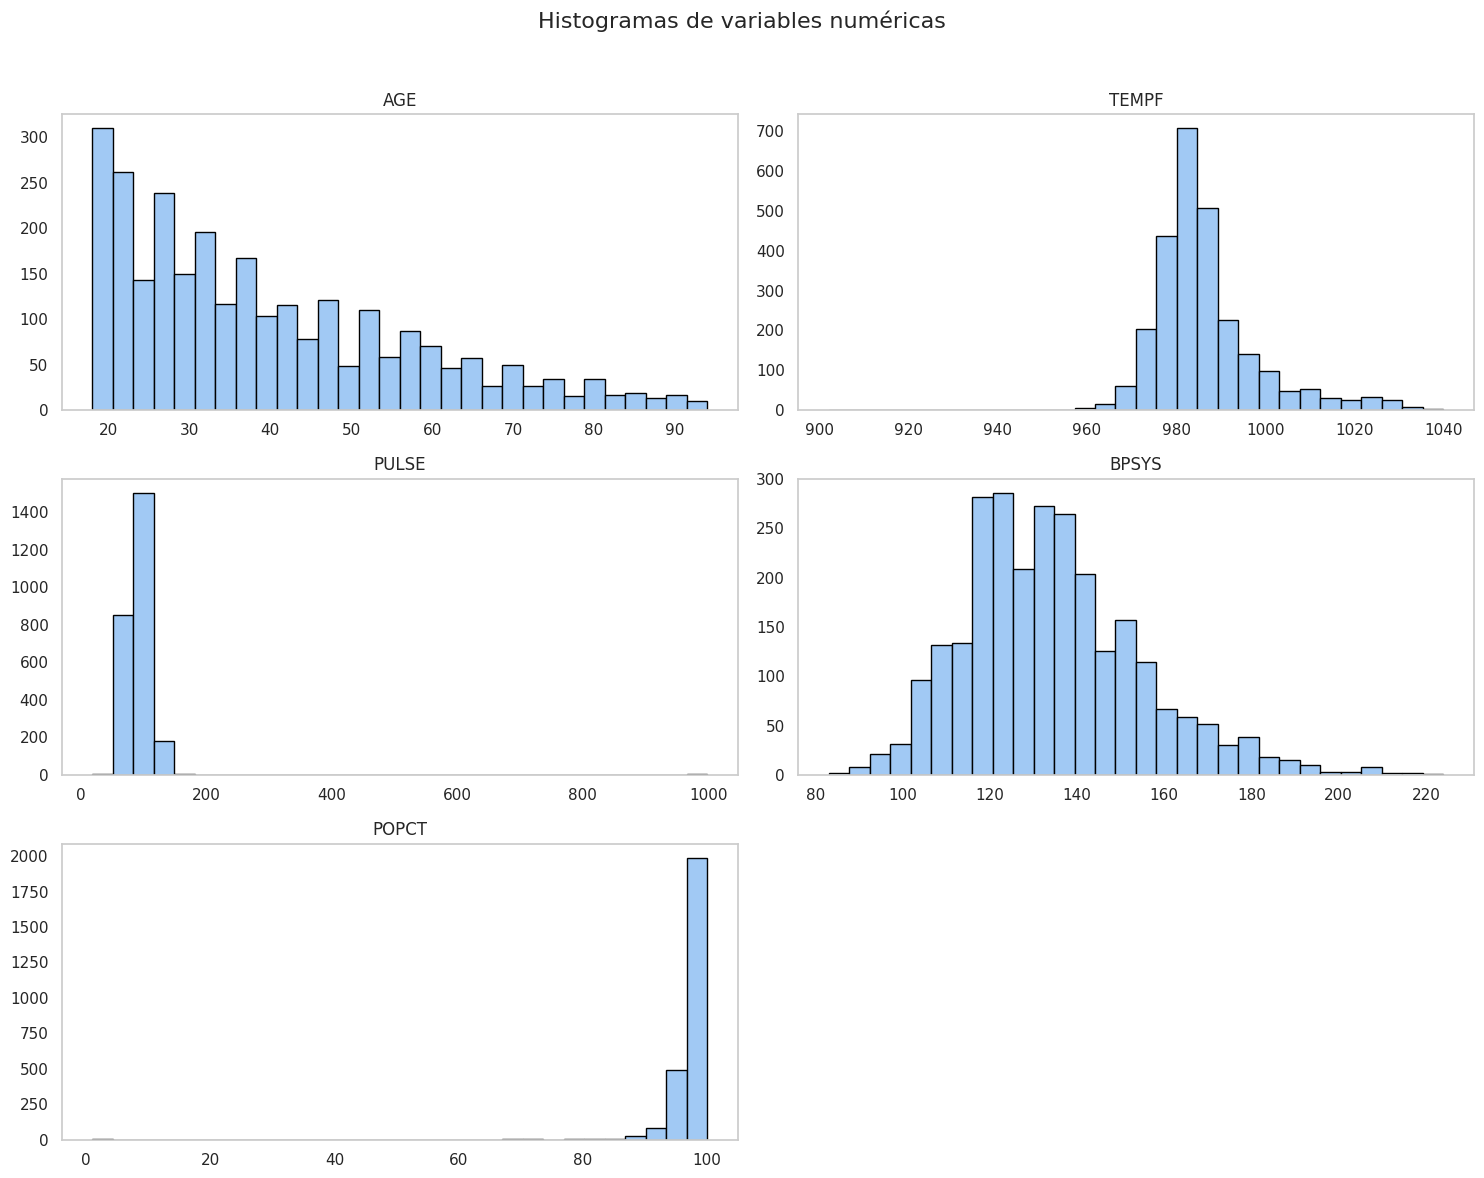

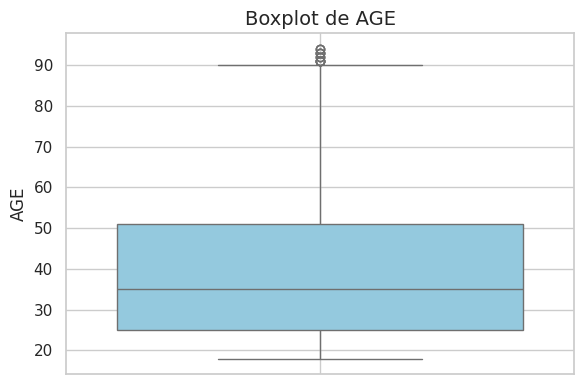

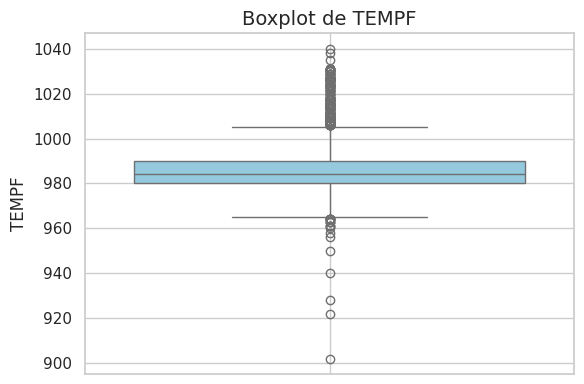

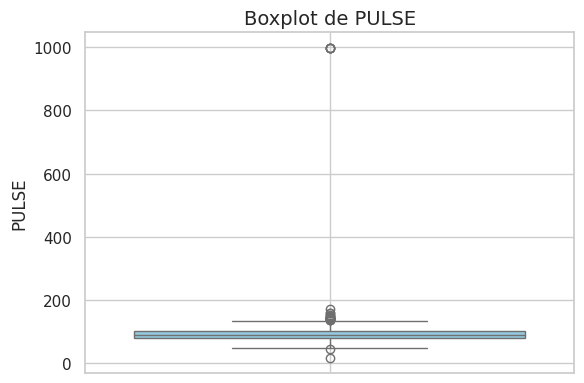

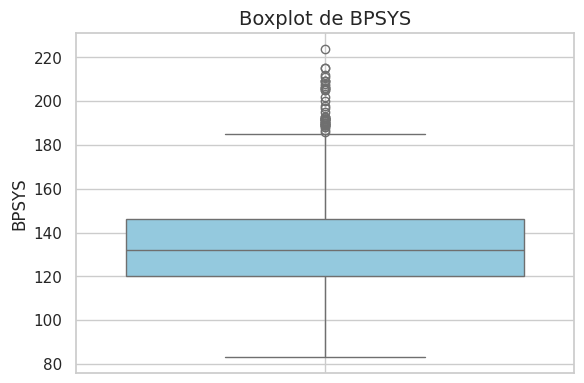

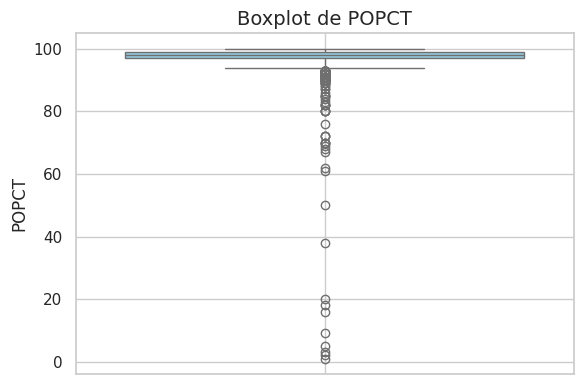


Conteo de outliers por variable numérica:
AGE: 16
TEMPF: 219
PULSE: 26
BPSYS: 45
POPCT: 147

R² de ANOVA entre variables categóricas y numéricas (R² > 0.05):
Variable Numérica   Variable Categórica       R²
              AGE             AGE_GROUP 0.926535
              AGE COMORB_CARDIOPULMONAR 0.265595
              AGE                   HTN 0.251967
              AGE     High_acuity_level 0.161545
            TEMPF          RAZON_VISITA 0.135424
            BPSYS                   HTN 0.119013
            POPCT     High_acuity_level 0.113935
            BPSYS COMORB_CARDIOPULMONAR 0.108806
            BPSYS             AGE_GROUP 0.094087
              AGE                  COPD 0.062606
            BPSYS     High_acuity_level 0.061627
              AGE          RAZON_VISITA 0.061441


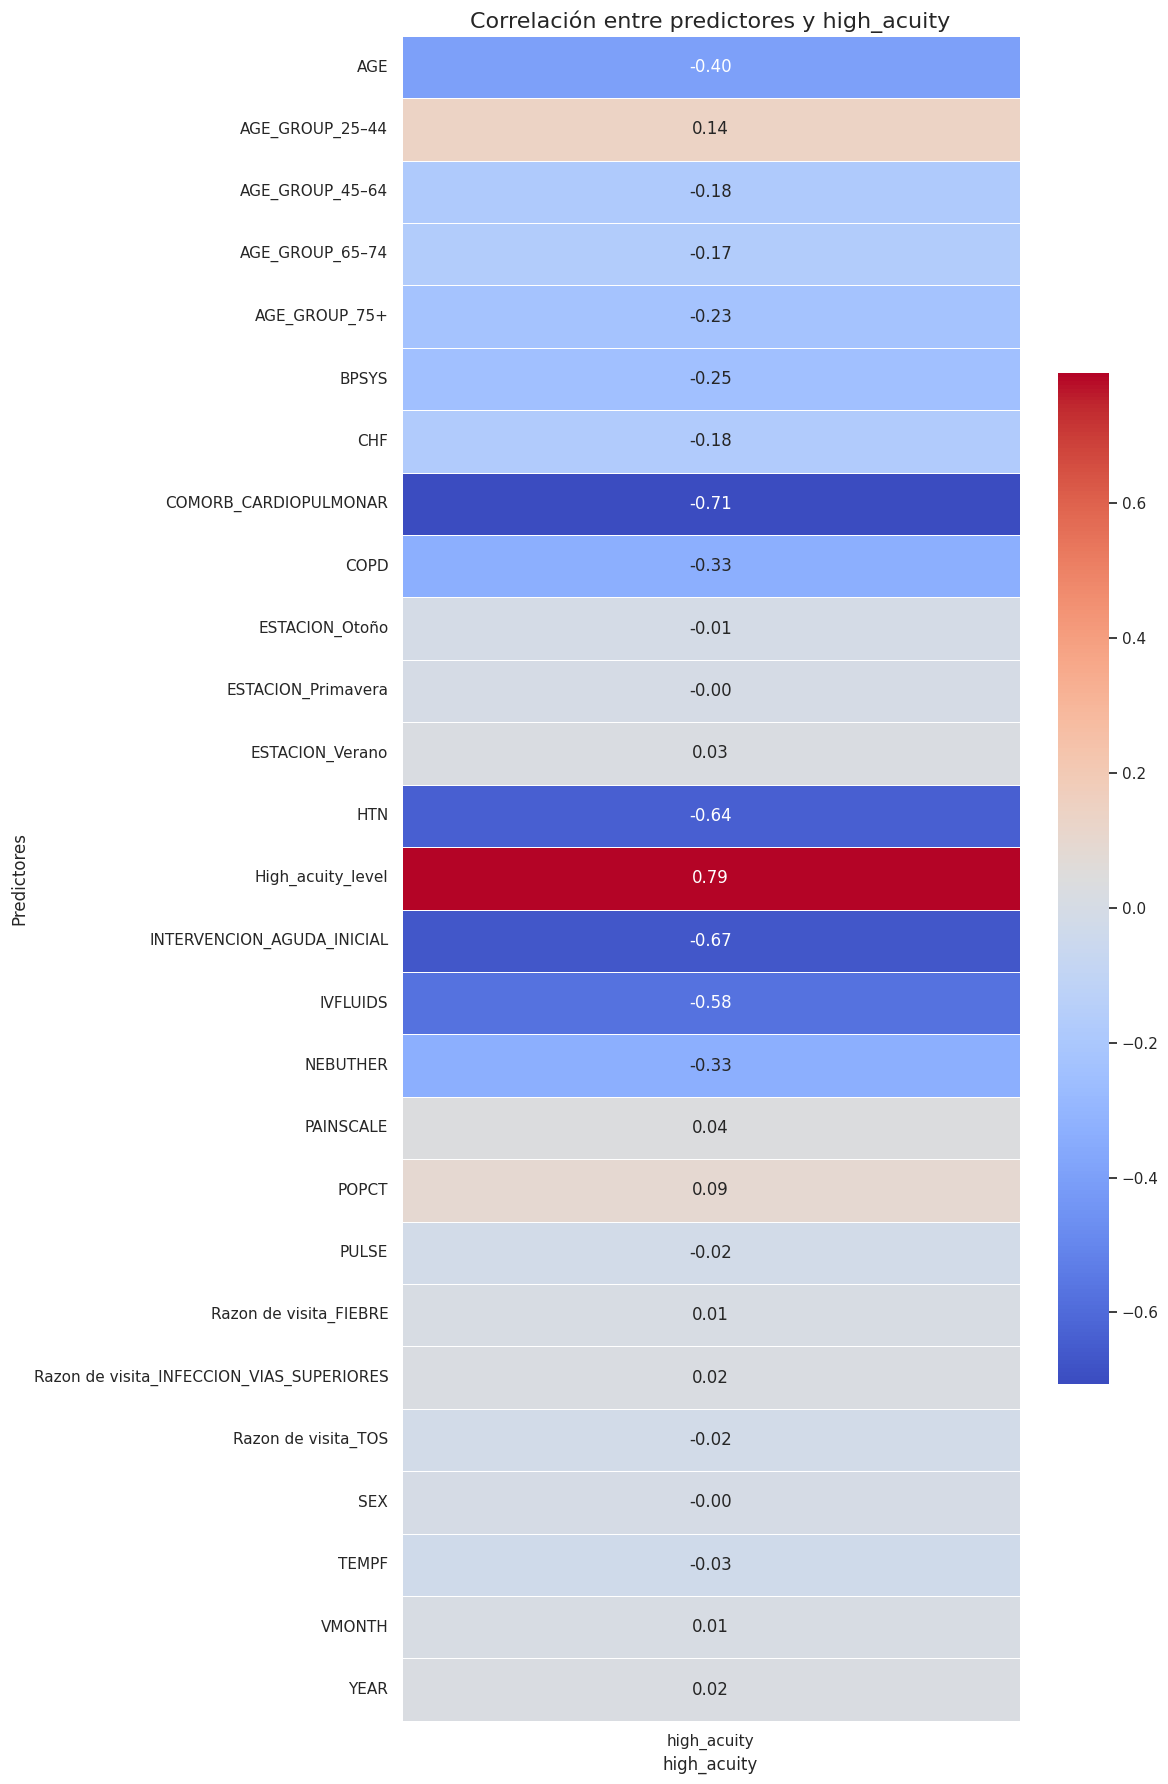


Correlaciones fuertes (>|0.3|) entre predictores y high_acuity:
High_acuity_level             0.792773
COMORB_CARDIOPULMONAR        -0.705689
INTERVENCION_AGUDA_INICIAL   -0.667849
HTN                          -0.636765
IVFLUIDS                     -0.576626
AGE                          -0.395847
COPD                         -0.332075
NEBUTHER                     -0.332075
Name: high_acuity, dtype: float64


In [7]:
from sklearn.preprocessing import LabelEncoder

# Variables categóricas, ordinales y numéricas
V_nominal = [
    'VMONTH', 'SEX', 'COPD', 'HTN', 'CHF',
    'IVFLUIDS', 'NEBUTHER', 'ESTACION',
    'INTERVENCION_AGUDA_INICIAL', 'COMORB_CARDIOPULMONAR',
    'AGE_GROUP', 'Razon de visita'

]

V_ordinal = ['PAINSCALE','High_acuity_level']
V_razon = ['AGE', 'TEMPF', 'PULSE', 'BPSYS', 'POPCT']
V_intervalo = ['YEAR']
outcome = 'high_acuity'

# Resumen estadístico: Variables de razón
print("\nResumen estadístico: Variables de razón")
print(data_filtrada[V_razon].describe().T)

print("\nValores nulos por variable de razón:")
print(data_filtrada[V_razon].isna().sum())

# Resumen estadístico: Variables ordinales
print("\nResumen estadístico: Variables ordinales")
for var in V_ordinal:
    print(f"\nDistribución de {var}:")
    print(data_filtrada[var].value_counts(dropna=False))
    print("Distribución relativa (%):")
    print(data_filtrada[var].value_counts(normalize=True, dropna=False).apply(lambda x: f"{x:.2%}"))

# Resumen estadístico: Variables nominales
print("\nResumen estadístico: Variables nominales")
for var in V_nominal:
    if var in data_filtrada.columns:
        print(f"\nDistribución de {var}:")
        print(data_filtrada[var].value_counts(dropna=False))
        print("Distribución relativa (%):")
        print(data_filtrada[var].value_counts(normalize=True, dropna=False).apply(lambda x: f"{x:.2%}"))

# Variables de intervalo
print("\nConteo por año (intervalo)")
for var in V_intervalo:
    if var in data_filtrada.columns:
        print(f"\nDistribución de {var}:")
        print(data_filtrada[var].value_counts(dropna=False).sort_index())

# Distribución del outcome
print(f"\nDistribución de {outcome}:")
print(data_filtrada[outcome].value_counts(dropna=False))

# Gráficos categóricos
sns.set(style="whitegrid", palette="pastel")

for var in V_nominal:
    if var in data_filtrada.columns:
        plt.figure(figsize=(8, 4))
        sns.countplot(data=data_filtrada, x=var, order=data_filtrada[var].value_counts().index)
        plt.title(f'Distribución de {var}')
        plt.xlabel(var)
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Histogramas de variables numéricas
data_filtrada[V_razon].hist(bins=30, figsize=(15, 12), edgecolor='black', grid=False)
plt.suptitle('Histogramas de variables numéricas', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Boxplots para detectar outliers
for col in V_razon:
    if col in data_filtrada.columns:
        plt.figure(figsize=(6, 4))
        sns.boxplot(data=data_filtrada, y=col, color='skyblue')
        plt.title(f'Boxplot de {col}', fontsize=14)
        plt.ylabel(col)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Detección de outliers
def detectar_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)]

print("\nConteo de outliers por variable numérica:")
for col in V_razon:
    if col in data_filtrada.columns:
        outliers = detectar_outliers(data_filtrada[col])
        print(f"{col}: {len(outliers)}")

# Renombrar temporalmente las variables con espacios
data_anova = data_filtrada.copy()
data_anova = data_anova.rename(columns={'Razon de visita': 'RAZON_VISITA'})

print("\nR² de ANOVA entre variables categóricas y numéricas (R² > 0.05):")
r2_dict = []

# Usamos la lista renombrada de variables categóricas sin el outcome para evitar duplicados
categoricas_renombradas = [var if var != 'Razon de visita' else 'RAZON_VISITA' for var in V_nominal if var != outcome] + V_ordinal

for num_var in V_razon:
    for cat_var in categoricas_renombradas:
        if cat_var in data_anova.columns and data_anova[cat_var].nunique() > 1:
            formula = f"{num_var} ~ C({cat_var})"
            try:
                model = smf.ols(formula, data=data_anova).fit()
                r2_dict.append((num_var, cat_var, model.rsquared))
            except Exception as e:
                print(f"Error con fórmula: {formula} → {e}")

r2_df = pd.DataFrame(r2_dict, columns=["Variable Numérica", "Variable Categórica", "R²"])
r2_df = r2_df[r2_df["R²"] > 0.05].sort_values("R²", ascending=False)
print(r2_df.to_string(index=False))

# MATRIZ DE CORRELACIÓN ENTRE PREDICTORES Y OUTCOME
variables_categoricas = [var for var in V_nominal if var != outcome] + V_ordinal
variables_numericas = V_razon + V_intervalo

# Construir dataframe para correlación
vars_corr = variables_numericas + variables_categoricas + [outcome]
df_pred = data_filtrada[vars_corr].copy()

# Codificar variables categóricas (sin outcome)
df_dummies = pd.get_dummies(df_pred[variables_categoricas], drop_first=True)

# Codificar outcome con LabelEncoder para correlación numérica
le = LabelEncoder()
y_encoded = le.fit_transform(df_pred[outcome].astype(str))

# Construir dataframe final para correlación
df_modelo = pd.concat([df_pred[variables_numericas], df_dummies], axis=1)
df_modelo[outcome] = y_encoded

# Calcular correlación
matriz_corr = df_modelo.corr().loc[df_modelo.columns.difference([outcome]), outcome]

# Heatmap
plt.figure(figsize=(12, 18))
sns.heatmap(matriz_corr.to_frame(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar_kws={"shrink": 0.6})
plt.title(f"Correlación entre predictores y {outcome}", fontsize=16)
plt.xlabel(outcome, fontsize=12)
plt.ylabel("Predictores", fontsize=12)
plt.tight_layout()
plt.show()

# Correlaciones fuertes
umbral = 0.3
corr_fuertes = matriz_corr[matriz_corr.abs() > umbral].sort_values(key=abs, ascending=False)
print(f"\nCorrelaciones fuertes (>|{umbral}|) entre predictores y {outcome}:")
print(corr_fuertes)


**RESULTADOS**:
1. **Variables numéricas** (de razón)
Edad (AGE): Promedio de 39 años, con mayoría entre 25–51 años. Hay pacientes muy mayores (hasta 94 años), y 16 outliers.

Temperatura (TEMPF): Promedio cercano a 98.6°F (normal), pero se detectaron 219 outliers, lo que sugiere posibles errores de medición o fiebre alta.

Pulso (PULSE): Media de 93 latidos/min, con algunos valores extremos (máximo 998), probablemente erróneos.

Presión sistólica (BPSYS): Promedio normal (134 mmHg), pero con 45 outliers hacia niveles muy altos.

Saturación de oxígeno (POPCT): Alta en general (promedio 97%), pero algunos valores extremos indican hipoxia severa o errores.

2. **Variables ordinales**
Escala de dolor (PAINSCALE): Muy dispersa, con más del 15% reportando dolor cero, pero también se observa mucho dolor (8–10) en casi un tercio de los pacientes.

High_acuity_level: La mayoría se concentra en los niveles 1 y 2 (gravedad media y alta).

3. **Variables nominales**
Sexo (SEX): 63% hombres.
HTN (hipertensión): Presente en el 21% de los casos.
COPD: 6.8% de los pacientes.
CHF (fallo cardíaco): Muy baja presencia (2%).
Intervención aguda: 23% de los pacientes la requirió.
Comorbilidad cardiopulmonar: Presente en 25% de los pacientes.
Estación: Invierno concentra la mayor proporción de casos (38%).
Grupo etario más común: 25–44 años (43%).
Razón de visita: En muchos casos no registrada (62% faltante), pero destacan fiebre y disnea.

4. Distribución del outcome high_acuity
Alta o media gravedad: Representan el 97% de los casos con dato conocido.
Baja gravedad o desconocido: Muy poco representados.

5. Relación entre variables (ANOVA)
Las variables categóricas con mayor capacidad explicativa (R² > 0.05) sobre variables numéricas son:
AGE_GROUP explica el 92% de la variación de la edad.
HTN, comorbilidades y High_acuity_level tienen asociaciones moderadas con edad, presión y saturación.

6. Correlaciones fuertes con high_acuity
Positivas: High_acuity_level (muy fuerte: 0.79)
Negativas: Comorbilidades cardiopulmonares, intervención aguda, hipertensión, IV fluids, edad, y COPD están fuertemente asociadas a mayor gravedad, con correlaciones entre -0.3 y -0.7.

Este fragmento de código implementa un modelo de clasificación supervisada para predecir si un paciente adulto con enfermedad respiratoria del tracto superior presenta una condición clínica de gravedad Alta (high_acuity == 'Alta'). El proceso se realiza comparando esta clase con todas las demás (Media, Baja, Desconocido), utilizando dos algoritmos: Regresión Logística y Random Forest.

Primero, se filtran los datos válidos y se crea la variable binaria target_alta, que toma el valor 1 para pacientes de gravedad Alta y 0 para los demás. Se seleccionan variables predictoras clínicas y demográficas relevantes, como edad agrupada (AGE_GROUP), intervención aguda, comorbilidades cardiopulmonares, signos graves, razón de visita, sexo, escala de dolor y estación del año. Las variables numéricas se escalan con StandardScaler, y las categóricas se codifican con One-Hot Encoding.

Luego, el conjunto de datos se divide en entrenamiento (70%) y prueba (30%) con estratificación, garantizando la proporción de casos Alta y No Alta. Se entrena primero un modelo de regresión logística con clases balanceadas, evaluando su rendimiento con un reporte de clasificación (precisión, recall, F1-score) y una matriz de confusión. También se presentan los coeficientes del modelo, lo que permite interpretar el efecto de cada variable en la predicción.

Posteriormente, se entrena un modelo de Random Forest con parámetros por defecto y ponderación de clases. Además de las métricas estándar y la matriz de confusión, se muestra un ranking de importancia de variables, destacando las más influyentes en la clasificación.

Adicionalmente, ambos modelos se evalúan gráficamente mediante las curvas ROC (Receiver Operating Characteristic), que representan la sensibilidad vs. el (1 – especificidad) a distintos umbrales de clasificación. Se calcula también el AUC (Área Bajo la Curva ROC), que resume la capacidad discriminativa del modelo: cuanto más se acerque a 1, mejor será el desempeño. Este análisis permite comparar visualmente qué modelo clasifica mejor entre pacientes de alta gravedad y el resto.


Reporte de Clasificación - Regresión Logística:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       122
           1       1.00      1.00      1.00       102

    accuracy                           1.00       224
   macro avg       1.00      1.00      1.00       224
weighted avg       1.00      1.00      1.00       224



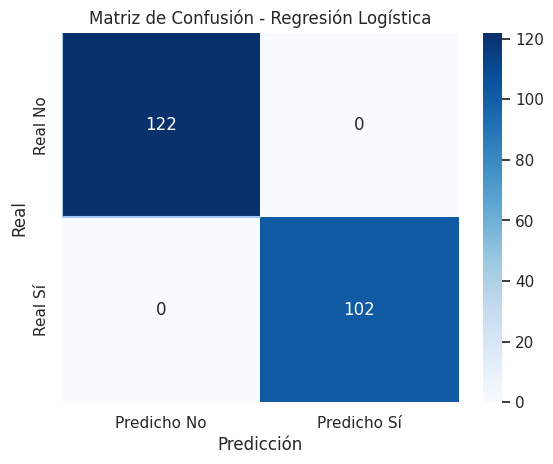


Coeficientes - Regresión Logística:
                                     Variable  Coeficiente
6                INTERVENCION_AGUDA_INICIAL_1     5.940322
7                     COMORB_CARDIOPULMONAR_1     5.377561
4                             AGE_GROUP_65–74     0.746509
8                      Razon de visita_FIEBRE    -0.456030
9   Razon de visita_INFECCION_VIAS_SUPERIORES    -0.405950
5                               AGE_GROUP_75+     0.375595
3                             AGE_GROUP_45–64     0.339419
11                                    SEX_2.0    -0.177070
2                             AGE_GROUP_25–44     0.115432
1                                   PAINSCALE    -0.072044
0                               SIGNOS_GRAVES    -0.039521
12                             ESTACION_Otoño    -0.014953
10                        Razon de visita_TOS    -0.013869
14                            ESTACION_Verano     0.008356
13                         ESTACION_Primavera    -0.007907

Reporte de Clasifi

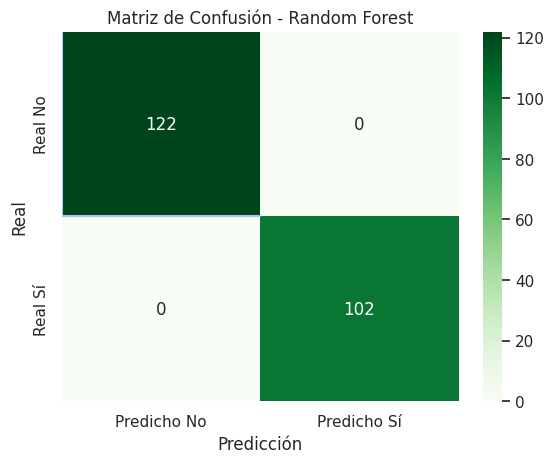


Importancia de Variables - Random Forest:
                                     Variable  Importancia
6                INTERVENCION_AGUDA_INICIAL_1     0.511565
7                     COMORB_CARDIOPULMONAR_1     0.315294
1                                   PAINSCALE     0.045920
8                      Razon de visita_FIEBRE     0.016837
3                             AGE_GROUP_45–64     0.016267
5                               AGE_GROUP_75+     0.014129
4                             AGE_GROUP_65–74     0.013305
9   Razon de visita_INFECCION_VIAS_SUPERIORES     0.012635
11                                    SEX_2.0     0.010187
2                             AGE_GROUP_25–44     0.009925
14                            ESTACION_Verano     0.009319
13                         ESTACION_Primavera     0.008627
12                             ESTACION_Otoño     0.007894
0                               SIGNOS_GRAVES     0.007374
10                        Razon de visita_TOS     0.000723


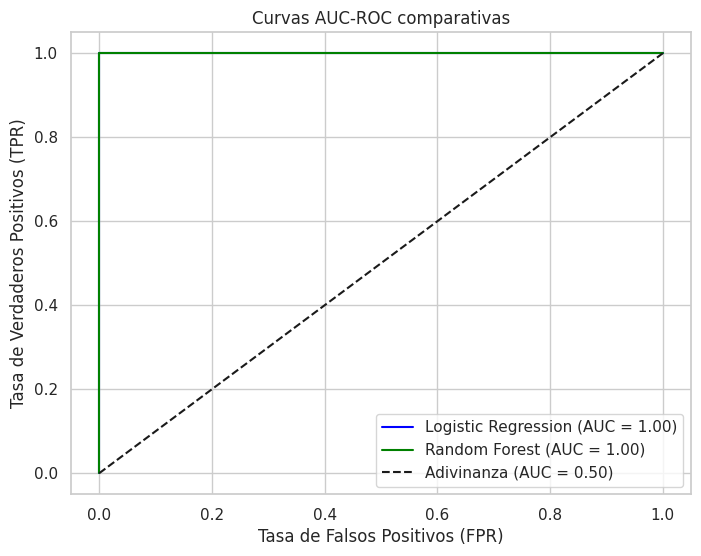

In [8]:
# 1. Filtrar observaciones válidas
df_modelo = data_filtrada[data_filtrada['high_acuity'].isin(['Alta', 'Media', 'Baja', 'Desconocido'])].copy()

# 2. Crear variable objetivo binaria: Alta vs No Alta
df_modelo['target_alta'] = (df_modelo['high_acuity'] == 'Alta').astype(int)
target = 'target_alta'

# 3. Definir predictores
predictoras = [
    'AGE_GROUP', 'INTERVENCION_AGUDA_INICIAL', 'COMORB_CARDIOPULMONAR',
    'SIGNOS_GRAVES', 'Razon de visita', 'SEX', 'PAINSCALE', 'ESTACION'
]
df_modelo = df_modelo[predictoras + [target]].dropna()

# 4. Escalar variables numéricas
num_vars = ['SIGNOS_GRAVES', 'PAINSCALE']
scaler = StandardScaler()
df_modelo[num_vars] = scaler.fit_transform(df_modelo[num_vars])

# 5. Codificar variables categóricas
cat_vars = ['AGE_GROUP', 'INTERVENCION_AGUDA_INICIAL', 'COMORB_CARDIOPULMONAR', 'Razon de visita', 'SEX', 'ESTACION']
df_modelo = pd.get_dummies(df_modelo, columns=cat_vars, drop_first=True)

# 6. Definir X e y
X = df_modelo.drop(columns=[target])
y = df_modelo[target]

# 7. Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# =========================
# MODELO 1: Regresión Logística
# =========================
log_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

print(f"\nReporte de Clasificación - Regresión Logística:")
print(classification_report(y_test, y_pred_log))

# AUC-ROC - Regresión Logística
roc_auc_log = roc_auc_score(y_test, y_prob_log)
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')

# Matriz de confusión
cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicho No', 'Predicho Sí'],
            yticklabels=['Real No', 'Real Sí'])
plt.title("Matriz de Confusión - Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Coeficientes
coef_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Coeficiente': log_model.coef_.flatten()
}).sort_values(by='Coeficiente', key=abs, ascending=False)
print("\nCoeficientes - Regresión Logística:")
print(coef_df)

# =========================
# MODELO 2: Random Forest
# =========================
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print(f"\nReporte de Clasificación - Random Forest:")
print(classification_report(y_test, y_pred_rf))

# AUC-ROC - Random Forest
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicho No', 'Predicho Sí'],
            yticklabels=['Real No', 'Real Sí'])
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Importancia de variables
importancia_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': rf_model.feature_importances_
}).sort_values(by='Importancia', ascending=False)
print("\nImportancia de Variables - Random Forest:")
print(importancia_df)

# CURVA AUC-ROC COMPARATIVA

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinanza (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas AUC-ROC comparativas')
plt.legend()
plt.grid(True)
plt.show()


Los resultados obtenidos al aplicar modelos de regresión logística y Random Forest para predecir si un paciente con enfermedad del tracto respiratorio superior presenta un cuadro de alta gravedad clínica. Ambos modelos fueron entrenados y evaluados sobre una muestra balanceada de pacientes, y sus métricas de rendimiento indican una clasificación perfecta en el conjunto de prueba: precisión, recall y f1-score fueron del 100% tanto para los pacientes con gravedad alta como para aquellos sin esta condición. Este rendimiento perfecto, si bien es ideal desde un punto de vista técnico, también puede ser una señal de que los datos están muy bien separados o que el modelo está sobreajustado al conjunto de entrenamiento, lo cual puede limitar su capacidad de generalización a nuevos casos.

En cuanto a la interpretación de los coeficientes del modelo de regresión logística, se observa que las variables más influyentes para predecir una condición de alta gravedad son principalmente clínicas. La más determinante es haber recibido una intervención aguda inicial, como terapia nebulizada o administración de fluidos intravenosos, lo cual aumenta significativamente la probabilidad de que un paciente sea clasificado como grave (coeficiente: +5.95). Le sigue en importancia la presencia de comorbilidades cardiopulmonares (EPOC, hipertensión, insuficiencia cardíaca), que también eleva notablemente esa probabilidad (coeficiente: +5.42). Asimismo, pertenecer a un grupo etario mayor —especialmente entre 65–74 años (+0.75) o mayores de 75 (+0.35)— incrementa moderadamente la probabilidad de gravedad alta.

En contraste, algunas variables están asociadas a una menor probabilidad de gravedad. Por ejemplo, consultar por fiebre (–0.39) o por infecciones respiratorias de vías superiores (–0.34) se relaciona negativamente con el diagnóstico de alta gravedad, lo que sugiere que estos síntomas pueden reflejar cuadros clínicos más leves en este grupo de pacientes. El nivel de dolor (PAINSCALE) también tiene una relación negativa aunque débil (–0.09), lo que sugiere que el dolor no es un factor determinante de gravedad en este tipo de consulta respiratoria.

El modelo de Random Forest, aunque no entrega coeficientes interpretables en términos lineales, permite identificar qué variables fueron más importantes para la predicción. En este caso, la importancia relativa de las variables confirma los hallazgos de la regresión. La intervención aguda inicial fue el predictor más importante con un 50.5% de peso en el modelo, seguido por la comorbilidad cardiopulmonar con un 32.2%. En conjunto, estas dos variables explican más del 82% de la capacidad predictiva del modelo. Otras variables, como el nivel de dolor, la edad o la estación del año, tienen una importancia mucho menor, lo que indica que su influencia en la predicción es secundaria.

Luego se realiza para el otro caso: si un paciente con enfermedad del tracto respiratorio superior ha sido clasificado como de gravedad media (Media) frente a cualquier otro nivel de gravedad (Alta, Baja o Desconocido). Se implementan dos modelos de machine learning: regresión logística y Random Forest.




Reporte de Clasificación - Regresión Logística (target_media):
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       153
           1       0.95      1.00      0.97       162

    accuracy                           0.97       315
   macro avg       0.97      0.97      0.97       315
weighted avg       0.97      0.97      0.97       315



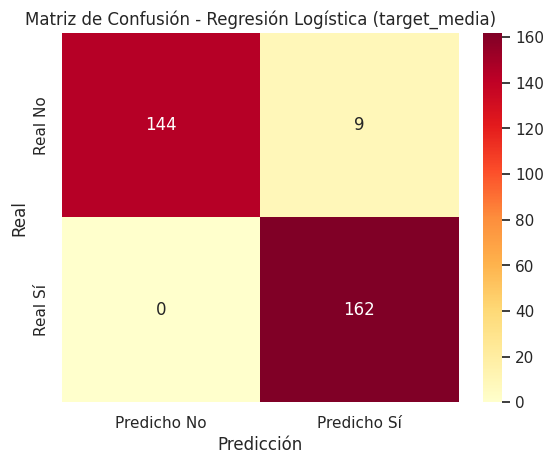


Coeficientes del modelo (Regresión Logística):
                                    Variable  Coeficiente
8  Razon de visita_INFECCION_VIAS_SUPERIORES     0.959117
7                     Razon de visita_FIEBRE     0.615383
0                              SIGNOS_GRAVES     0.359634
9                        Razon de visita_TOS     0.071716
1                            AGE_GROUP_25–44    -0.076260
4                              AGE_GROUP_75+    -0.154021
2                            AGE_GROUP_45–64    -0.326829
3                            AGE_GROUP_65–74    -0.848122
6                    COMORB_CARDIOPULMONAR_1    -5.445879
5               INTERVENCION_AGUDA_INICIAL_1    -5.910667

Intercepto del modelo: 2.1934501269171545

Reporte de Clasificación - Random Forest (target_media):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       153
           1       0.98      0.98      0.98       162

    accuracy                           0.98      

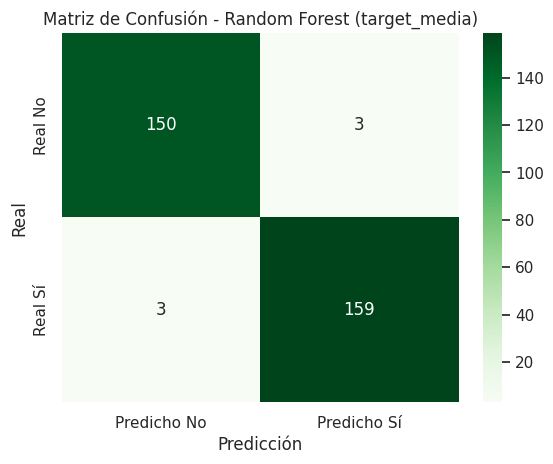


Importancia de Variables - Random Forest:
                                    Variable  Importancia
5               INTERVENCION_AGUDA_INICIAL_1     0.508963
6                    COMORB_CARDIOPULMONAR_1     0.367799
0                              SIGNOS_GRAVES     0.050565
7                     Razon de visita_FIEBRE     0.017295
8  Razon de visita_INFECCION_VIAS_SUPERIORES     0.014820
3                            AGE_GROUP_65–74     0.014024
4                              AGE_GROUP_75+     0.012285
2                            AGE_GROUP_45–64     0.010284
1                            AGE_GROUP_25–44     0.003882
9                        Razon de visita_TOS     0.000083


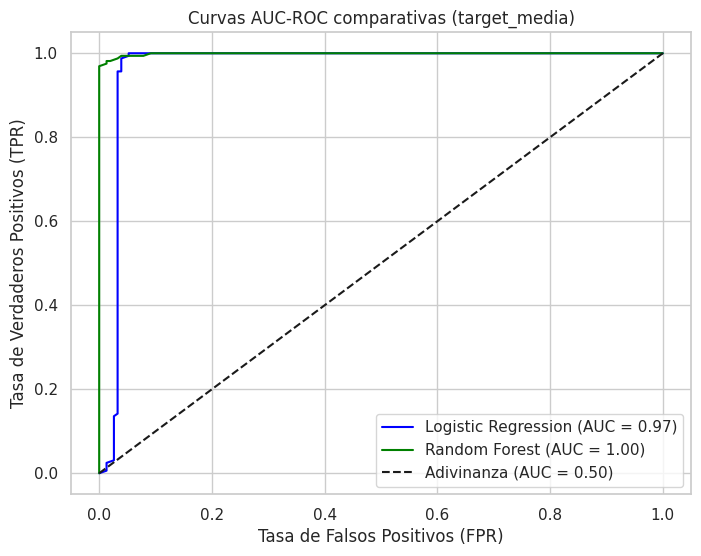

In [9]:
# 1. Filtrar observaciones válidas (Alta, Media, Baja, Desconocido)
df_modelo = data_filtrada[data_filtrada['high_acuity'].isin(['Alta', 'Media', 'Baja', 'Desconocido'])].copy()

# 2. Definir variable objetivo binaria: Media vs No Media
df_modelo['target_media'] = (df_modelo['high_acuity'] == 'Media').astype(int)
target = 'target_media'

# 3. Seleccionar predictores
predictoras = ['AGE_GROUP', 'INTERVENCION_AGUDA_INICIAL', 'COMORB_CARDIOPULMONAR',
               'SIGNOS_GRAVES', 'Razon de visita']
df_modelo = df_modelo[predictoras + [target]].dropna()

# 4. Separar variables
num_vars = ['SIGNOS_GRAVES']
cat_vars = ['AGE_GROUP', 'INTERVENCION_AGUDA_INICIAL', 'COMORB_CARDIOPULMONAR', 'Razon de visita']

# 5. Escalar numéricas
scaler = StandardScaler()
df_modelo[num_vars] = scaler.fit_transform(df_modelo[num_vars])

# 6. Codificar categóricas
df_modelo = pd.get_dummies(df_modelo, columns=cat_vars, drop_first=True)

# 7. Definir X e y
X = df_modelo.drop(columns=[target])
y = df_modelo[target]

# 8. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# =======================
# MODELO 1: REG. LOGÍSTICA
# =======================
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logistic_model.fit(X_train, y_train)

y_pred_log = logistic_model.predict(X_test)
y_prob_log = logistic_model.predict_proba(X_test)[:, 1]

print(f"\nReporte de Clasificación - Regresión Logística ({target}):")
print(classification_report(y_test, y_pred_log))

# AUC-ROC - Regresión Logística
roc_auc_log = roc_auc_score(y_test, y_prob_log)
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)

# Matriz de confusión
cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=['Predicho No', 'Predicho Sí'],
            yticklabels=['Real No', 'Real Sí'])
plt.title(f'Matriz de Confusión - Regresión Logística ({target})')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Coeficientes
coefficients = logistic_model.coef_.flatten()
intercept = logistic_model.intercept_[0]
column_names = X_train.columns

coef_df = pd.DataFrame({
    'Variable': column_names,
    'Coeficiente': coefficients
}).sort_values(by='Coeficiente', ascending=False)
print("\nCoeficientes del modelo (Regresión Logística):")
print(coef_df)
print(f"\nIntercepto del modelo: {intercept}")

# =======================
# MODELO 2: RANDOM FOREST
# =======================
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print(f"\nReporte de Clasificación - Random Forest ({target}):")
print(classification_report(y_test, y_pred_rf))

# AUC-ROC - Random Forest
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicho No', 'Predicho Sí'],
            yticklabels=['Real No', 'Real Sí'])
plt.title(f"Matriz de Confusión - Random Forest ({target})")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Importancia de variables
importancia_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': rf_model.feature_importances_
}).sort_values(by='Importancia', ascending=False)
print("\nImportancia de Variables - Random Forest:")
print(importancia_df)

# CURVA AUC-ROC COMPARATIVA

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinanza (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title(f'Curvas AUC-ROC comparativas ({target})')
plt.legend()
plt.grid(True)
plt.show()


Los resultados obtenidos para la predicción de pacientes con gravedad media (target_media) muestran un excelente desempeño de ambos modelos: regresión logística y Random Forest. La regresión logística alcanzó un 97% de precisión global (accuracy), con un f1-score también de 0.97 para ambas clases (Media vs. No Media). El modelo demostró ser especialmente preciso al identificar correctamente a los pacientes con gravedad media (recall = 1.00), y también fue muy eficaz al detectar correctamente a quienes no pertenecen a este grupo (precisión = 1.00).

En cuanto a la interpretación de los coeficientes del modelo de regresión logística, los mayores valores positivos están asociados a los motivos de consulta respiratorios, en particular las infecciones de vías respiratorias superiores (+0.96) y la fiebre (+0.61), lo que sugiere que estos síntomas aumentan considerablemente la probabilidad de que un paciente sea clasificado como de gravedad media. También los signos clínicos graves tienen un efecto positivo más moderado (+0.36). Por otro lado, los grupos etarios más avanzados presentan coeficientes negativos, siendo más marcada la disminución en el grupo de 65–74 años (–0.85), lo cual indica que los pacientes mayores tienden a no ser clasificados como de gravedad media, sino más bien como graves o desconocidos.

Sin embargo, los dos predictores con mayor efecto negativo en la predicción fueron la presencia de comorbilidades cardiopulmonares (–5.45) y la intervención aguda inicial (–5.91), lo que implica que los pacientes que presentan estos indicadores tienden a ser clasificados como casos de alta gravedad en lugar de media.

El modelo de Random Forest confirmó estas relaciones, asignando mayor importancia a las mismas variables clínicas. En concreto, la intervención aguda inicial fue la más relevante (50.9% de la importancia del modelo), seguida por la comorbilidad cardiopulmonar (36.8%). Las demás variables, como signos graves, fiebre o edad, tuvieron una influencia menor. Como en el modelo anterior, el motivo de consulta por tos fue prácticamente irrelevante.

**Conclusiones:**
**Predominancia de casos de gravedad media y alta**
Del total de 2.740 pacientes adultos con enfermedades del tracto respiratorio superior, la mayoría fueron clasificados como de gravedad media (57.5%) y alta (39.5%), siendo muy pocos los casos considerados leves (0.5%) o desconocidos (2.4%). Esto sugiere una alta carga de complejidad clínica dentro de la muestra analizada.

**Alta efectividad de los modelos predictivos**
Tanto la regresión logística como el Random Forest mostraron una precisión superior al 97% en la clasificación binaria de gravedad alta y media. Esto demuestra que los modelos implementados son altamente efectivos para identificar pacientes en riesgo elevado, y pueden ser utilizados como herramientas de apoyo a la toma de decisiones clínicas.

**Importancia clínica de ciertas variables**
En ambos modelos (alta y media), se identificaron consistentemente tres variables clave con fuerte capacidad predictiva:

INTERVENCIÓN_AGUDA_INICIAL (como terapia nebulizada o fluidos intravenosos),

COMORBILIDAD_CARDIOPULMONAR (EPOC, hipertensión, insuficiencia cardíaca),

y SIGNOS_GRAVES (anomalías fisiológicas como fiebre, baja saturación o presión).

Estas variables reflejan condiciones críticas que justifican clasificaciones de mayor gravedad y son coherentes clínicamente.

**Influencia del motivo de consulta**
En el modelo de gravedad media, motivos como infección de vías respiratorias superiores y fiebre fueron los que más se asociaron a esa clasificación. Esto confirma que los síntomas iniciales, aunque comunes, no deben subestimarse, ya que pueden derivar en condiciones que requieren atención intermedia.

**Factores demográficos y estacionales con menor peso predictivo**
Las variables como grupo etario, sexo y estación del año tuvieron menor impacto predictivo directo en los modelos, aunque se mantienen relevantes desde una perspectiva epidemiológica para la planificación de recursos y estrategias de prevención.

**Recomendaciones**
**Implementar sistemas de alerta temprana**
Se recomienda integrar modelos predictivos como los desarrollados en este estudio en plataformas clínicas para alertar de forma automatizada cuando un paciente cumple con patrones asociados a alta gravedad, optimizando así la priorización y asignación de recursos.

**Priorizar pacientes con intervenciones agudas y comorbilidades**
Los servicios de urgencia deben prestar especial atención a pacientes que reciban intervenciones inmediatas o que presenten comorbilidades cardiopulmonares, ya que estos factores son fuertemente predictivos de alta gravedad.

**Mejorar la documentación de motivos de consulta (RFV)**
Dado que el motivo de consulta mostró utilidad en la predicción de gravedad media, es importante garantizar una adecuada codificación y recolección de estas variables en los sistemas clínicos.

**Fortalecer la vigilancia estacional**
Aunque la estación del año no fue decisiva en los modelos, los datos muestran una mayor frecuencia de casos en invierno y primavera, lo cual es útil para anticipar aumentos estacionales de demanda asistencial y ajustar la capacidad operativa de los centros de salud.

**Extender la aplicación del modelo a otros grupos de edad o condiciones**
Dado el éxito del modelo en pacientes adultos con enfermedades del tracto superior, se recomienda evaluar su aplicabilidad en poblaciones pediátricas o en otras afecciones respiratorias como neumonía o influenza.